## Summary

Online shopping plays an important role in our daily life. When selecting online products, customers’ reviews are an aspect to pay attention to. Current quality of reviews are uneven. Short or meaningless reviews, and even sabotage reviews can happen, which seriously affects customers’ shopping experience and their choices of products.  

Our goal is to use ensemble learning to predict the quality of reviews in real-life scenarios. The data is provided by Amazon.  
Both Bagging and Adaboost.M1 frameworks are used for ensembles. The prediction results are evaluated by AUC scores.  

Ensemble learning helps improve machine learning results by combining several models. These two decrease the variance of a single estimate as they combine several estimates from different models. So the result may be a model with higher stability.  

The best performances on the test set are carried out by:  
1. Bagging + DecisionTree--Gini, Max Depth:2, Minimum Split:100 (ROC AUC: 0.76)
2. AdaBoost.M1--Itr:2 + LinearSVM--C=0.7(ROC AUC: 0.80).

In [1]:
import pandas as pd 
import numpy as np

import string
import re
import random
import sys

import seaborn as sb
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
# nltk.download('stopwords')
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import ComplementNB, GaussianNB, MultinomialNB
from sklearn.svm import SVC
from scipy.sparse import csr_matrix

from sklearnex import patch_sklearn 
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## 1. Data Pre-processing

In [3]:
train_df = pd.read_csv('./data/train.csv', sep='\t')
test_df = pd.read_csv('./data/test.csv', sep='\t')

In [4]:
display(train_df)
display(test_df)

reviewerID   asin                                         reviewText  \
0            7885   3901  First off, allow me to correct a common mistak...   
1           52087  47978  I am really troubled by this Story and Enterta...   
2            5701   3667  A near-perfect film version of a downright glo...   
3           47191  40892  Keep your expectations low.  Really really low...   
4           40957  15367  "they dont make em like this no more..."well.....   
...           ...    ...                                                ...   
57034       58315  29374  If you like beautifully shot, well acted films...   
57035       23328  45548  This is a great set of films Wayne did Fox and...   
57036       27203  42453  It's what's known as a comedy of manners. It's...   
57037       33992  44891  Ellen can do no wrong as far a creating wonder...   
57038       27478  19198  I agree with everyone else that this is a grea...   

       overall  votes_up  votes_all  label  
0          5.0         6          7      0  
1          3.0        99        134      0  
2          4.0        14         14      1  
3          1.0         4          7      0  
4          5.0         3          6      0  
...        ...       ...        ...    ...  
57034      2.0        12         21      0  
57035      5.0        15         18      0  
57036      3.0         4          5      0  
57037      5.0         4          5      0  
57038      2.0         5          5      1  

[57039 rows x 7 columns]

Id  reviewerID   asin  \
0          0       82947  37386   
1          1       10154  23543   
2          2        5789   5724   
3          3        9198   5909   
4          4       33252  21214   
...      ...         ...    ...   
11203  11203       18250  35309   
11204  11204        3200   2130   
11205  11205       37366  41971   
11206  11206        1781  33089   
11207  11207       26372  35457   

                                              reviewText  overall  
0      I REALLY wanted this series but I am in SHOCK ...      1.0  
1      I have to say that this is a work of art for m...      4.0  
2      Alien 3 is certainly the most controversal fil...      3.0  
3      I love this film...preachy?  Well, of course i...      5.0  
4      Even though I previously bought the Gamera Dou...      5.0  
...                                                  ...      ...  
11203  I honestly never heard of the graphic novel un...      5.0  
11204  Archie Bunker's command to stifle YOURSELF! wa...      5.0  
11205  In LSD - My Problem Child, Albert Hoffman wrot...      5.0  
11206  I have owned this DVD for over a year now and ...      5.0  
11207  This movie is just a slap in the face [or othe...      1.0  

[11208 rows x 5 columns]

### 1.1 Drop features an Invalid Samples

We can see that in the test dataset, "votes_up" and "votes_all" are missing.  
One way is to drop the features. We could also use other features to interpolate missing values, but this could potentially introduce in over-fitting.  

Besides, the labels are directly set by the return values from votes_up/votes_all ≥ 0.9. The learning on IDs and textual contents would be comparatively meaningless, as the relationship between labels and votes is clearly known.  

In this section, we will use this rule to detect invalid samples, too.

In [5]:
# find invalid data based on the nature of the LOL game (may vary depends on the task)
invalid = train_df[
    (train_df["votes_up"]/train_df["votes_all"]<0.9)&
    (train_df["label"]==1)
]
invalid.empty

True

In [6]:
train_df = train_df.drop(columns=["votes_up", "votes_all"])

### 1.2 Numeric Features Analysis

In [7]:
def display_heatmap(data_frame: pd.DataFrame) -> None:
    # display for better visulization
    # ref: https://www.educba.com/seaborn-heatmap-size/
    # ref: https://stackoverflow.com/questions/39409866/correlation-heatmap
    plt.figure(figsize = (10,10))
    sb.heatmap(data_frame, cmap=sb.cubehelix_palette(as_cmap=True), annot=True, fmt=".2f")

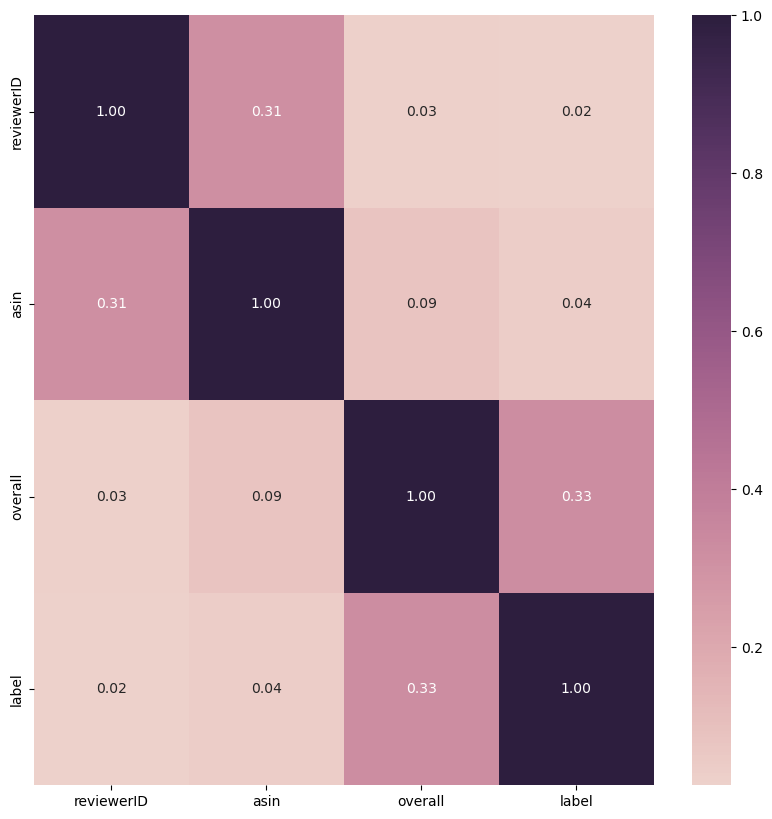

In [8]:
ids_df = train_df.loc[:, ["reviewerID", "asin", "overall", "label"]]
correlation_matrix = train_df.corr().abs()
display_heatmap(correlation_matrix)

Feature "reviewerID" and "asin" have extreme low correlation with the label we are going to predict.  
As a reflection of real-life, if a product(same ID) has good quality, then the reviewer might give a good feedback and vote up for it.   

ref: https://stats.stackexchange.com/questions/535931/encoding-id-variables-for-machine-learning  
Another reason we move ID-related features is: "One of the general rules of building usable machine learning models is that you never include features that won't be available at prediction time, account ID is one of such features".   
Technically, ID can be encoded using something like feature hashing, but this would only mean that for an unknown ID you would be using another, random ID from the training set.

In [9]:
train_df = train_df.drop(columns=["reviewerID", "asin"])
train_df

reviewText  overall  label
0      First off, allow me to correct a common mistak...      5.0      0
1      I am really troubled by this Story and Enterta...      3.0      0
2      A near-perfect film version of a downright glo...      4.0      1
3      Keep your expectations low.  Really really low...      1.0      0
4      "they dont make em like this no more..."well.....      5.0      0
...                                                  ...      ...    ...
57034  If you like beautifully shot, well acted films...      2.0      0
57035  This is a great set of films Wayne did Fox and...      5.0      0
57036  It's what's known as a comedy of manners. It's...      3.0      0
57037  Ellen can do no wrong as far a creating wonder...      5.0      0
57038  I agree with everyone else that this is a grea...      2.0      1

[57039 rows x 3 columns]

### 1.3 Language Processing: Sentiment

ref: https://medium.com/@goodrebels/how-to-apply-machine-learning-to-customer-feedback-b81cb01d3c3c 
热风： https://towardsdatascience.com/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524  

One popular processing for catagorizing feedbacks is sentiment detection on textual contents.  
Textblob module will be used to analyze polarity abd subjectivity.  

Polarity lies between [-1,1], -1 defines a negative sentiment and 1 defines a positive sentiment.  
Subjectivity lies between [0,1]. Subjectivity quantifies the amount of personal opinion and factual information contained in the text. The higher subjectivity means that the text contains personal opinion rather than factual information. 

Except sentiment extraction, the length of a customer's feedback can also associate with the quality of products in some way (or subjective way). We will extract this out and apply further analysis.

In [10]:
def get_subjectivity(texts):
    return TextBlob(texts).sentiment.subjectivity

def get_polarity(texts):
    return TextBlob(texts).sentiment.polarity

def get_length(texts):
    return len(texts)

train_df["polarity"] = train_df["reviewText"].apply(get_polarity)
train_df["subjectivity"] = train_df["reviewText"].apply(get_subjectivity)
train_df["length"] = train_df["reviewText"].apply(get_length)

# normalize overall ranks to [0,1]
new_overall = (train_df["overall"]-train_df["overall"].min())/(train_df["overall"].max()-train_df["overall"].min()) 
train_df["overall"] = new_overall

# normalize lenths to [0,1]
new_length = (train_df["length"]-train_df["length"].min())/(train_df["length"].max()-train_df["length"].min()) 
train_df["length"] = new_length

In [11]:
train_df

reviewText  overall  label  \
0      First off, allow me to correct a common mistak...     1.00      0   
1      I am really troubled by this Story and Enterta...     0.50      0   
2      A near-perfect film version of a downright glo...     0.75      1   
3      Keep your expectations low.  Really really low...     0.00      0   
4      "they dont make em like this no more..."well.....     1.00      0   
...                                                  ...      ...    ...   
57034  If you like beautifully shot, well acted films...     0.25      0   
57035  This is a great set of films Wayne did Fox and...     1.00      0   
57036  It's what's known as a comedy of manners. It's...     0.50      0   
57037  Ellen can do no wrong as far a creating wonder...     1.00      0   
57038  I agree with everyone else that this is a grea...     0.25      1   

       polarity  subjectivity    length  
0      0.198494      0.598768  0.097724  
1      0.030000      0.503526  0.109919  
2      0.221667      0.575000  0.017171  
3     -0.106471      0.447059  0.028020  
4      0.037500      0.425000  0.022514  
...         ...           ...       ...  
57034  0.206563      0.649167  0.102292  
57035  0.086667      0.498889  0.081369  
57036  0.147941      0.427894  0.085080  
57037  0.194481      0.739935  0.014153  
57038  0.054960      0.456944  0.028061  

[57039 rows x 6 columns]

In [12]:
# we will apply same sentiment extract for test data
test_df = test_df.drop(columns=["reviewerID", "asin"])

test_df["polarity"] = test_df["reviewText"].apply(get_polarity)
test_df["subjectivity"] = test_df["reviewText"].apply(get_subjectivity)
test_df["length"] = test_df["reviewText"].apply(get_length)

# normalize overall ranks to [0,1]
new_overall = (test_df["overall"]-test_df["overall"].min())/(test_df["overall"].max()-test_df["overall"].min()) 
test_df["overall"] = new_overall

# normalize lenths to [0,1]
new_length = (test_df["length"]-test_df["length"].min())/(test_df["length"].max()-test_df["length"].min()) 
test_df["length"] = new_length

test_df

Id                                         reviewText  overall  \
0          0  I REALLY wanted this series but I am in SHOCK ...     0.00   
1          1  I have to say that this is a work of art for m...     0.75   
2          2  Alien 3 is certainly the most controversal fil...     0.50   
3          3  I love this film...preachy?  Well, of course i...     1.00   
4          4  Even though I previously bought the Gamera Dou...     1.00   
...      ...                                                ...      ...   
11203  11203  I honestly never heard of the graphic novel un...     1.00   
11204  11204  Archie Bunker's command to stifle YOURSELF! wa...     1.00   
11205  11205  In LSD - My Problem Child, Albert Hoffman wrot...     1.00   
11206  11206  I have owned this DVD for over a year now and ...     1.00   
11207  11207  This movie is just a slap in the face [or othe...     0.00   

       polarity  subjectivity    length  
0      0.200000      0.200000  0.005891  
1      0.296491      0.537719  0.030004  
2      0.016857      0.575482  0.065995  
3      0.333766      0.707143  0.012330  
4      0.246667      0.313333  0.014422  
...         ...           ...       ...  
11203  0.176799      0.444806  0.147603  
11204  0.038636      0.657576  0.017803  
11205  0.065549      0.535520  1.000000  
11206  0.151197      0.509484  0.097737  
11207 -0.003571      0.432143  0.010366  

[11208 rows x 6 columns]

### 1.4 Textual Contents Clean Up

In [13]:
def clean_text_contents(content):
    # including: lowering texts, punctuation removal, stop word removal
    content = content.lower()
    for punc in string.punctuation:
        content = content.replace(punc, "")
    # tokenization
    content = re.split(' ',content)
    # stop word removal
    stop_words = nltk.corpus.stopwords.words('english')
    cleaned_content = [i for i in content if i not in stop_words]
    return " ".join(cleaned_content)

In [14]:
textual_contents_clean = []
for content in train_df["reviewText"]:
    textual_contents_clean.append(clean_text_contents(content))

In [15]:
train_df["reviewText"] = textual_contents_clean
train_df

reviewText  overall  label  \
0      first allow correct common mistake made one re...     1.00      0   
1      really troubled story entertained way presente...     0.50      0   
2      nearperfect film version downright gloomy play...     0.75      1   
3      keep expectations low  really really low  may ...     0.00      0   
4      dont make em like morewell throw phrase window...     1.00      0   
...                                                  ...      ...    ...   
57034  like beautifully shot well acted films plot li...     0.25      0   
57035  great set films wayne fox mgm contains films l...     1.00      0   
57036  whats known comedy manners form entertainment ...     0.50      0   
57037  ellen wrong far creating wonderful workouts wo...     1.00      0   
57038  agree everyone else great film dvd unwatchable...     0.25      1   

       polarity  subjectivity    length  
0      0.198494      0.598768  0.097724  
1      0.030000      0.503526  0.109919  
2      0.221667      0.575000  0.017171  
3     -0.106471      0.447059  0.028020  
4      0.037500      0.425000  0.022514  
...         ...           ...       ...  
57034  0.206563      0.649167  0.102292  
57035  0.086667      0.498889  0.081369  
57036  0.147941      0.427894  0.085080  
57037  0.194481      0.739935  0.014153  
57038  0.054960      0.456944  0.028061  

[57039 rows x 6 columns]

We will do the same text cleanup on test set and apply the vectorizer from train set to test set.

In [16]:
textual_contents_clean = []
for content in test_df["reviewText"]:
    textual_contents_clean.append(clean_text_contents(content))
    
test_df["reviewText"] = textual_contents_clean

### 1.5 Vectorization

TF-IDF is first chosen for text vectorization.  

ref: https://www.deepwizai.com/projects/how-to-correctly-use-tf-idf-with-imbalanced-data  
When working with unbalanced dataset, since TF-IDF is selecting features based on term frequency alone, the minority class gets under-represented.   

We wilkl extract in total 300 terms from textual contexts, dimensionality reduction will be applied on the extracted features later.

In [17]:
def get_probability_count(label, classes = [0, 1]):
    """
    Get the occurence of class types in the label values array;
    label: [n*1] array for label values; based on current feature
    0 -> non spam
    1 -> spam

    return:
    label_class_counts: [label=0 count, label=1 count]
    """
    label_class_counts = []
    for label_class_type in classes:
        label_class_counts.append(list(label).count(label_class_type))
    return label_class_counts


# in raw data
neg, pos = get_probability_count(train_df["label"])
print("Negative product: {}".format(neg/(neg+pos)))
print("Positive product: {}".format(pos/(neg+pos)))

Negative product: 0.7738038885674714
Positive product: 0.22619611143252863


In [18]:
def draw_word_cloud(label, feature_train, max_words=200):
    plt.figure(figsize=(10,15))
    plt.rcParams['font.sans-serif']='SimHei'
    freq_data_frame = pd.DataFrame(feature_train, columns=label)
    feature_mean_freq_dict = dict(freq_data_frame.mean())
    word_cloud = WordCloud(background_color="white",width=1800,height=1800, 
                           max_words=max_words,relative_scaling=0.5,normalize_plurals=False,
                          font_path='simhei.ttf', prefer_horizontal=1).generate_from_frequencies(feature_mean_freq_dict)
    plt.imshow(word_cloud)

In [ ]:
# overall tfidf
vectorizer = TfidfVectorizer(min_df=0.01, ngram_range=(1,3), max_features=300)
model = vectorizer.fit(train_df["reviewText"])
train_term = model.get_feature_names_out()
train_term_freq = model.transform(train_df["reviewText"]).toarray()

#draw_word_cloud(train_term, train_term_freq, 200)

In [19]:
# weighted tfidf
neg_amount = int(300*0.774)
pos_amount = 300 - neg_amount

# get all train text contents with label 0
neg_contents = train_df.loc[train_df['label'] == 0]["reviewText"]
# get all train text contents with label 1
pos_contents = train_df.loc[train_df['label'] == 1]["reviewText"]

#run tfidf on majority class
vectorizer = TfidfVectorizer(min_df=0.01, max_features=neg_amount, ngram_range=(1,3))
model = vectorizer.fit(neg_contents)
vocabulary = list(model.vocabulary_.keys())

# run tfidf on majority class and use the vocabulary from above as stop words
vectorizer = TfidfVectorizer(min_df=0.01, max_features=pos_amount, ngram_range=(1,3), stop_words=vocabulary)
model = vectorizer.fit(pos_contents)
vocabulary += list(model.vocabulary_.keys())

In [ ]:
cvec_tfidf = TfidfVectorizer(analyzer="word", min_df = 0.01, max_df = 1, ngram_range=(1,3), vocabulary=vocabulary)
text_feature_name = cvec_tfidf.get_feature_names_out()
text_features_train = cvec_tfidf.fit_transform(train_df["reviewText"]).toarray()
draw_word_cloud(text_feature_name, text_features_train, 200)

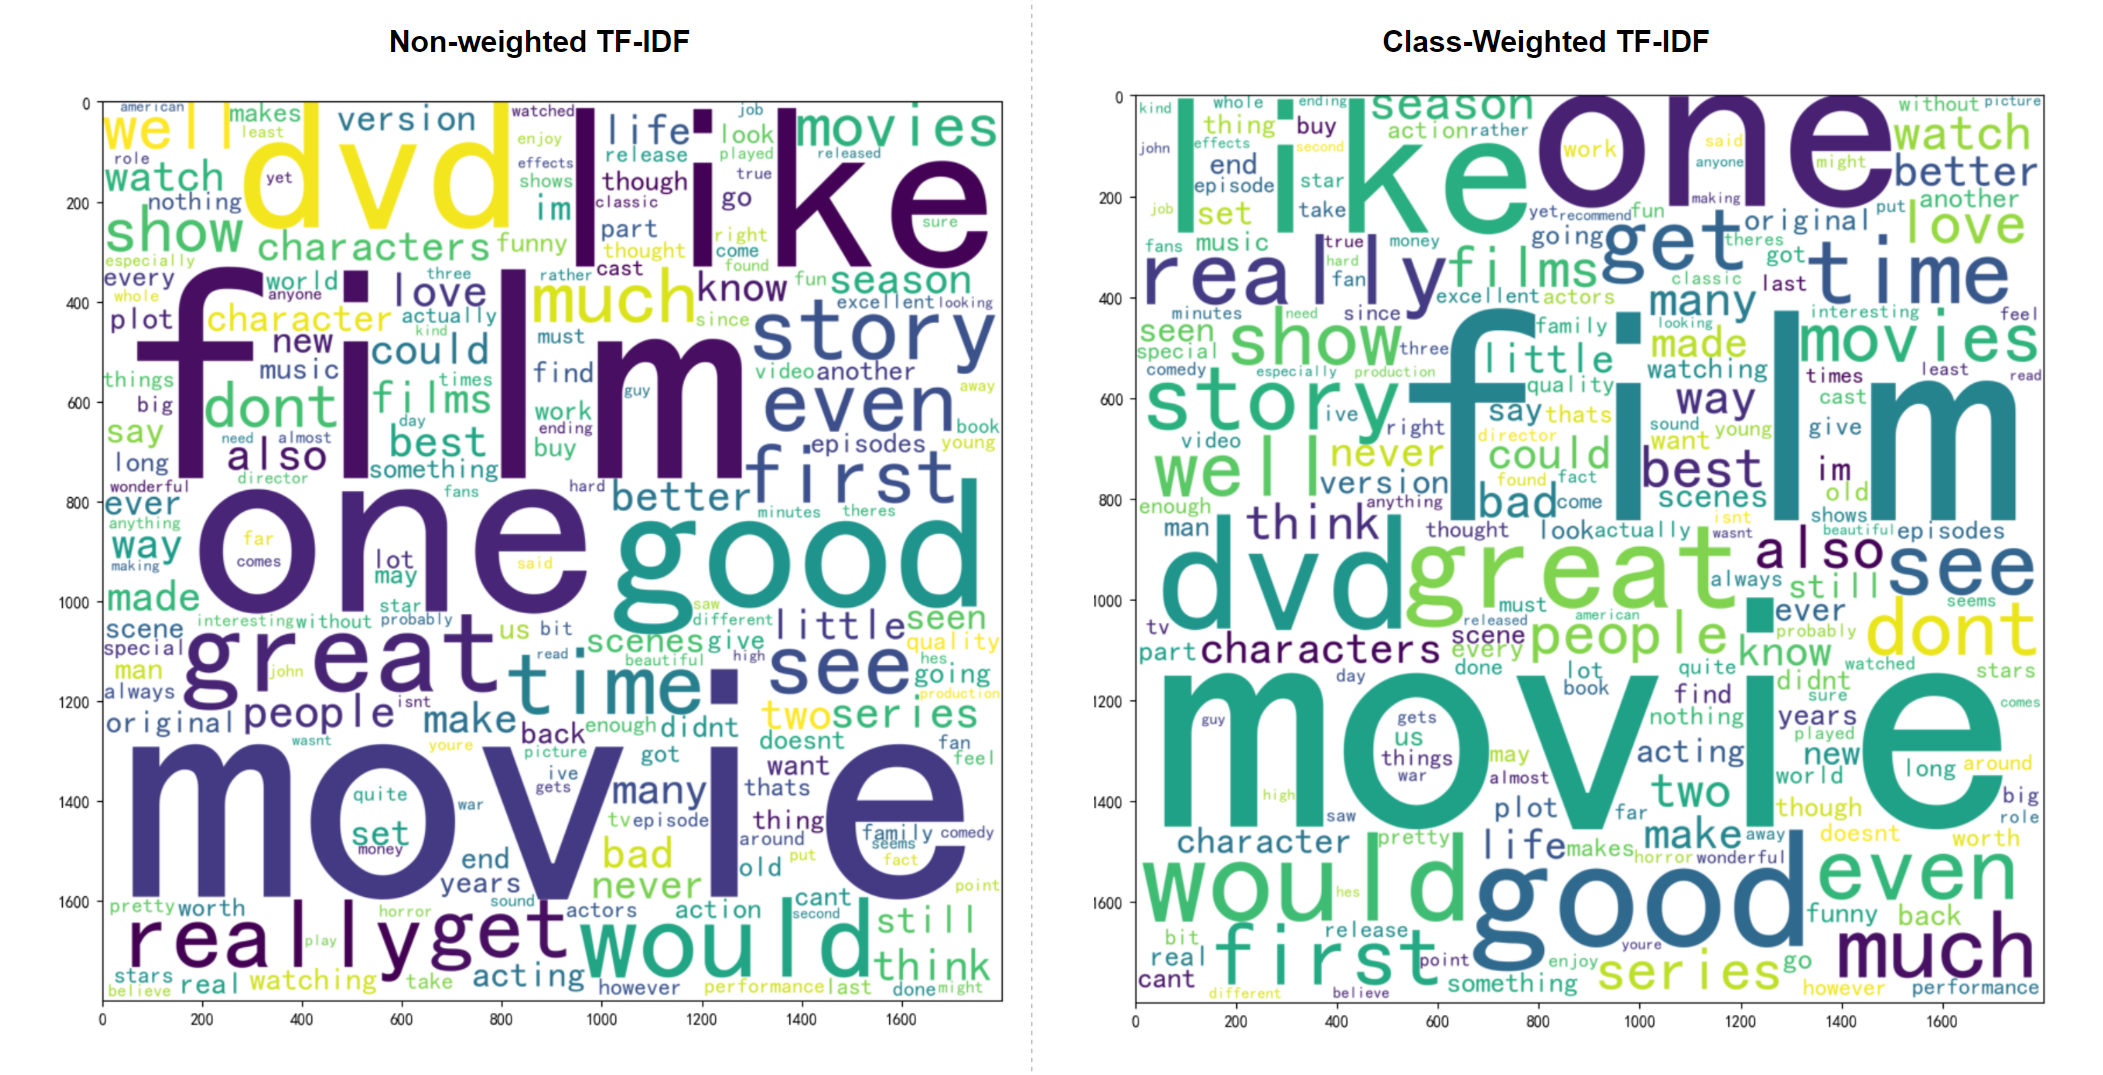
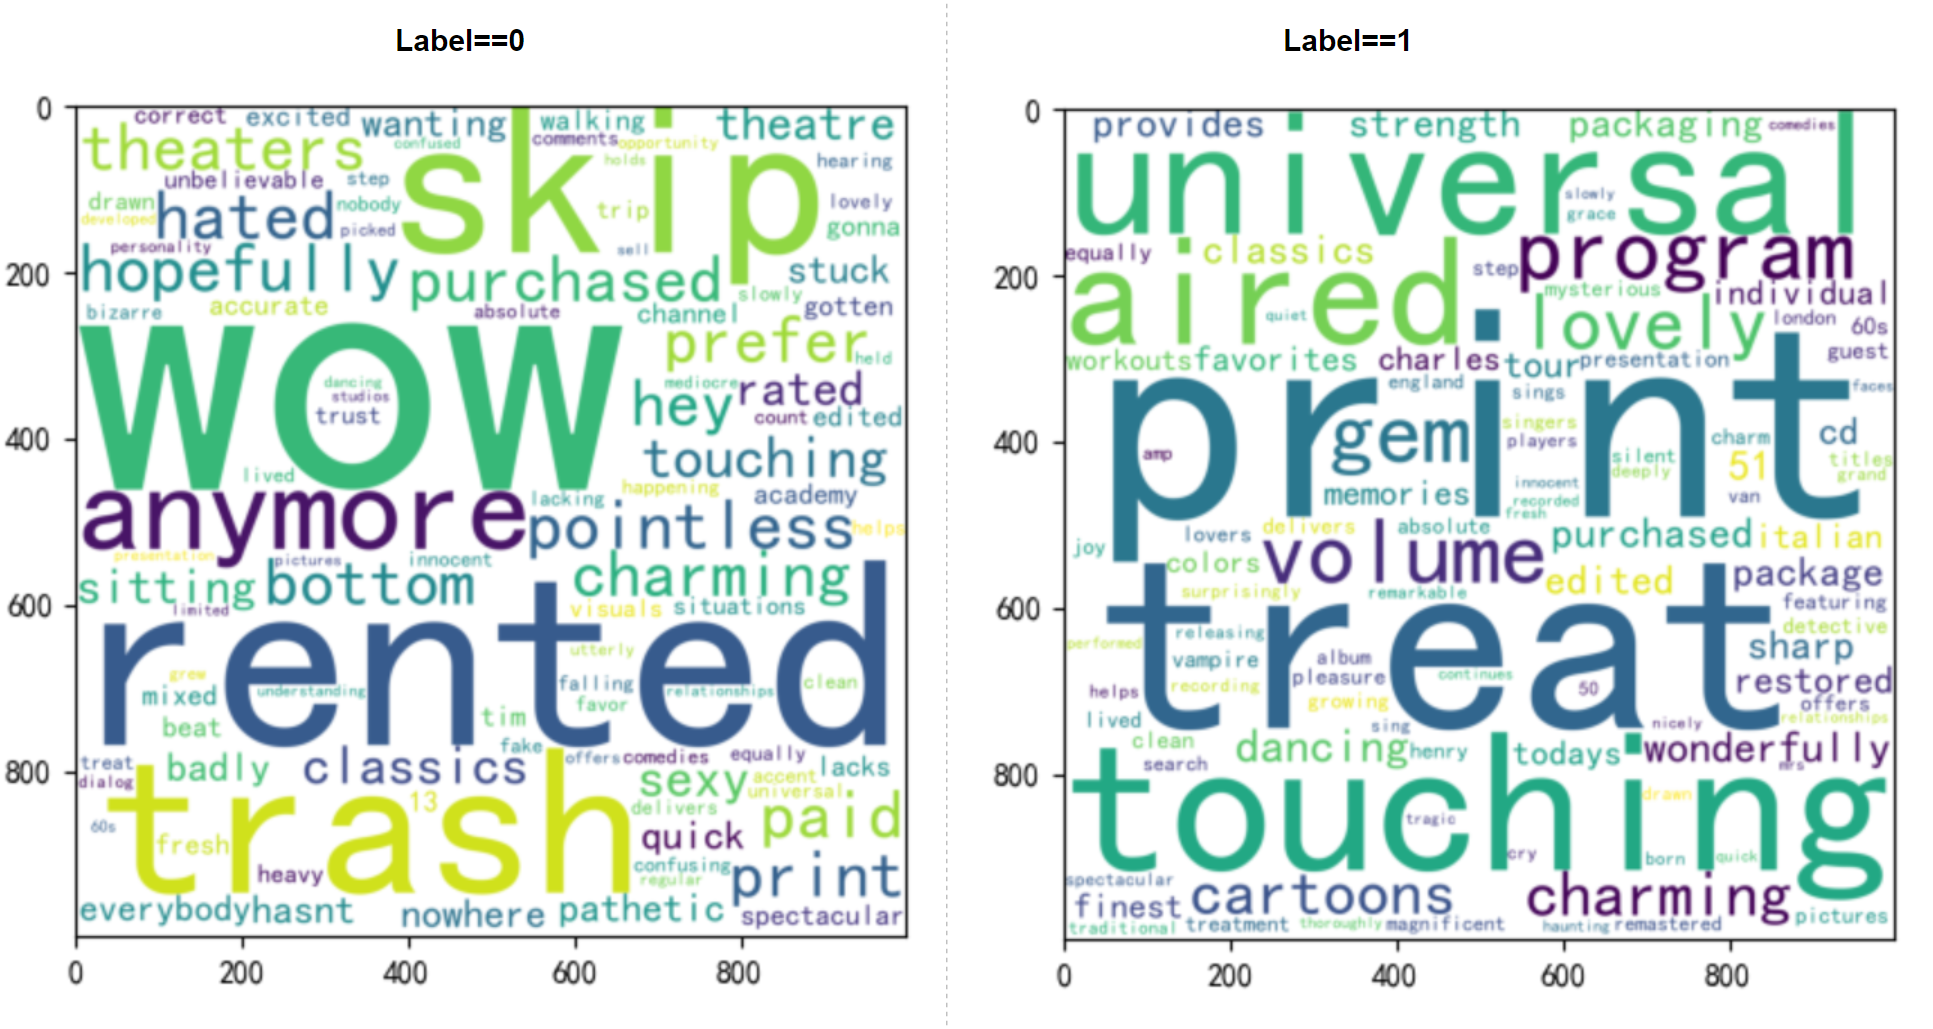

Two diagrams below shows the top 100 terms extracted from text contents that associated with labnel 0 or 1 only.  
Top two images are top 100 terms extracted from all text contexts in the train set.
Top left is vectorized by non-weighted TF-IDF, and top right is with class-weighted TF-IDF.  

From bottom images, we could see that terms representing classes can be quite different. Non-weighted TF-IDF could easily lead to low-interpretability.  
From the top images, we could also notice that weighted and non-weighted have differences, especially on mid-high frequency terms.  

We will stick with class-weighted TF-IDF for now. Next step is to use the same vocanulary to vectorize test set.

In [21]:
cvec_tfidf = TfidfVectorizer(analyzer="word", min_df = 0.01, max_df = 1, ngram_range=(1,3), vocabulary=vocabulary)
text_feature_name = cvec_tfidf.get_feature_names_out()
text_features_test = cvec_tfidf.fit_transform(test_df["reviewText"]).toarray()

### 1.6 Construct Final Train Set and Test Set

In [22]:
train_y = train_df["label"]

# normalize polarity cos negative values do not work with Naive Bayes in the later experiment
train_df["polarity"] = (train_df["polarity"]-train_df["polarity"].min())/(train_df["polarity"].max()-train_df["polarity"].min())
test_df["polarity"] = (test_df["polarity"]-test_df["polarity"].min())/(test_df["polarity"].max()-test_df["polarity"].min())

train_x = np.concatenate(
    (text_features_train, train_df.loc[:, ["length", "overall", "polarity", "subjectivity"]]), 
    axis=1
)
test_x = np.concatenate(
    (text_features_test, test_df.loc[:, ["length", "overall", "polarity", "subjectivity"]]), 
    axis=1
)

In [23]:
train_x.shape, test_x.shape

((57039, 304), (11208, 304))

## 2. Ensemble Learning Frame

In this section, we will implement Bagging and AdaBoost.M1 from scratch.  
For estimators in the ensembnle frame, we want to retun the predict probability rather than the predict result.  

ref: https://towardsdatascience.com/predict-vs-predict-proba-scikit-learn-bdc45daa5972  

### 2.1 Read Ground Truth of Test Set

In [24]:
ground_truth = pd.read_csv('./groundTruth.csv')
y_test = ground_truth["Expected"]

### 2.2 Bagging

ref: https://www.ibm.com/topics/bagging  
ref: https://machinelearningmastery.com/implement-bagging-scratch-python/  
ref: https://lifewithdata.com/2023/06/03/implementing-bagging-algorithm-from-scratch-in-python/  
Bagging, also known as bootstrap aggregation, is the ensemble learning method that is commonly used to reduce variance within a noisy dataset. 

In [25]:
def ensemble_proba(proba, w, weight="uniform"):
    """
    Different ways to interpolate predict probability;
    weight: "uniform" means un-weighted; "acc" means weighted by train accuracy
    """
    if weight=="uniform":
        # arithmetic mean
        mean_proba = np.mean(proba, axis=1)
    if weight=="acc":
        # weighted arithmetic mean
        w = np.array(w)
        mean_proba = np.dot(proba, w)
    class_0_proba = 1-mean_proba
    return np.concatenate((class_0_proba[:, np.newaxis], mean_proba[:, np.newaxis]), axis=1)

In [26]:
def get_subset_index(rand_range, ratio=0.1):
    """
    Take random samples from the main set with replacement
    oob: whether to retun oob indices
    """
    amount = round(rand_range*ratio)
    indices = random.sample(range(rand_range), amount)
    return indices

In [27]:
class Bagging:
    
    def __init__(self, 
                 base_model, 
                 max_itr, 
                 bootstrap_ratio=0.7, 
                 max_features=1.0, 
                 ensemble_weight="uniform"):
        """
        base_model: base estimator/classifier;
        itr: repeat times of sampling;
        bootstrap_ratio: samples to form a subset for bootstrap
        max_features: features to take to form subset
        ensemble_weight: uniform is non-weighted, acc is accuracy score weighted
        """
        self.max_itr = max_itr
        self.bootstrap_ratio = bootstrap_ratio
        self.max_features = max_features
        self.ensemble_weight = ensemble_weight
        
        self.estimators = [base_model for i in range(self.max_itr)]
        self.sub_features = []
        self.weights = []
    
    
    def fit(self, X, Y):
        # store weight for voting
        estimate_weight = []
        
        # store sub sample set and potential feature sub set
        x_subsets = []
        y_subsets = []
        x_oob_sets = []
        y_oob_sets = []
        
        feature_subset_index = []
        
        # get subset sample indices and perhaps feature indices for each estimator
        for itr in range(self.max_itr):
            # get row indices for samples in subset
            sub_sample_indices = get_subset_index(X.shape[0], self.bootstrap_ratio)
            # append y subset
            y_subsets.append(Y[sub_sample_indices])
            
            # if need to bootstrap on features
            if self.max_features == 1.0:
                new_features_X = X
            else:
                sub_feature_index = get_subset_index(X.shape[1], self.max_features)
                feature_subset_index.append(sub_feature_index)
                new_features_X = X[:, sub_feature_index]
                
            x_subsets.append(new_features_X[sub_sample_indices, :])
                
            # if weighted, need to get oob
            if self.ensemble_weight == "acc":
                mask = np.zeros((X.shape[0]), dtype=bool)
                mask[sub_sample_indices] = True
                # update out-of-bag x and y to calculate accuracy scores 
                x_oob_sets.append(new_features_X[~mask])
                y_oob_sets.append(Y[~mask])     
                
        # train each estimator
        trained_models = []
        for i, model in enumerate(self.estimators):
            # fit the estimator on asscociated x and y subset
            trained_model = model.fit(x_subsets[i], y_subsets[i])
            trained_models.append(trained_model)
            
            #print("fit estimator {}".format(i))
            
            # if weight set to "acc", we need to run trained model on oob
            # the accuracy score will be the weight for the estimator
            if self.ensemble_weight == "acc":
                oob_y_hat = trained_model.predict(x_oob_sets[i])
                # get the accuracy score
                estimate_weight.append(accuracy_score(y_oob_sets[i], oob_y_hat))
        #print(estimate_weight)
                
        # now update the Bagging regressor
        self.estimators = trained_models
        self.sub_features = feature_subset_index
        
        if not estimate_weight:
            self.weights = []
        # normalize weight
        else:
            estimate_weight = np.array(estimate_weight)
            normalized_weight = estimate_weight*(1/sum(estimate_weight))
            self.weights = list(normalized_weight) 
        
        # testing
        #print(self.weights)
    
    
    def predict_proba(self, X):
        proba_list = []
        # iterate each estimator
        # for each test data point, proba will be a (1*n) array, n=classes amount
        # our case is binary, we will take only one prob from (1*2) array for lighter calc
        for i, model in enumerate(self.estimators):
            if self.max_features == 1.0:
                proba = model.predict_proba(X)[:, 1][:, np.newaxis]
            else:
                les_feature_X = X[:, self.sub_features[i]]
                proba = model.predict_proba(les_feature_X)[:, 1][:, np.newaxis]
            proba_list.append(proba)
        # combine all data points' probability from each estimator
        all_proba = np.concatenate(proba_list, axis=1)
        
        # interpolate probability
        pred_proba = ensemble_proba(all_proba, self.weights, self.ensemble_weight)
        return pred_proba
 
    
    def predict(self, X, pred_proba=None):
        if pred_proba is not None: 
            pred_proba = self.predict_proba(X)
        
        hat = np.zeros(pred_proba.shape[0])
        for i in range(pred_proba.shape[0]):
            if pred_proba[i][0]<pred_proba[i][1]:
                hat[i] = 1
        return hat
    

In [29]:
base_model = DecisionTreeClassifier(max_depth=2, min_samples_split=1000)
classifier = Bagging(base_model, 3, 0.6, 1.0, "acc")

In [79]:
classifier.fit(train_x, train_y)

fit estimator 0
fit estimator 1
fit estimator 2
[0.7749824684431977, 0.7750262973352033, 0.7712131837307152]
[0.33386831819640866, 0.33388720001510547, 0.33224448178848587]


In [80]:
proba = classifier.predict_proba(test_x)

In [81]:
y_pred = classifier.predict(test_x, proba)

In [82]:
accuracy_score(y_test, y_pred)

0.8087080656673804

In [83]:
roc_auc_score(y_test, proba[:,1])

0.73014548904309

### 2.3 AdaBoost.M1

ref: https://machinelearningmastery.com/boosting-and-adaboost-for-machine-learning/  
ref: https://towardsdatascience.com/adaboost-from-scratch-37a936da3d50  

One of tha advantage of AdaBoost.M1, as suggested by some AI forums, is that it is best used to boost the performance of decision trees on binary classification problems. 
It is also proved to be sufficiently functional with weak classifiers, which basically means the hypothesis can be quite simple and light weighted.  
Compared to Bagging, few parameters need to be tuned and no prior learning knowledge is needed. 

In [28]:
def update_sample_weights(sample_weights, y_true, y_pred, alpha):
    new_weights = np.ones(len(sample_weights))
    
    for i in range(len(sample_weights)):
        if y_true[i] == y_pred[i]:
            new_weights[i] = sample_weights[i] * np.exp(-alpha)
        else:
            new_weights[i] = sample_weights[i] * np.exp(alpha)
            
    # normalize weights
    new_weights = new_weights*(1/sum(new_weights))
    return new_weights

In [29]:
def get_error(y_true, y_pred, weights):
    err = 0.0
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            err += weights[i]
    return err

In [30]:
def get_beta(err):
    return err/(1.0-err)

In [31]:
def weighted_proba(proba, w):
    w = np.array(w)
    proba = np.dot(proba, w)
    class_0_proba = 1-proba
    return np.concatenate((class_0_proba[:, np.newaxis], proba[:, np.newaxis]), axis=1)

In [32]:
class AdaBoost:
    def __init__(self, base_model, max_itr):
        """
        base_model: base estimator/classifier;
        itr: repeat times of sampling;
        """
        self.max_itr = max_itr
        
        self.estimators = [base_model for i in range(self.max_itr)]
        self.alphas = np.zeros(max_itr)
        
    
    def fit(self, X, Y):
        
        for itr in range(self.max_itr):
            if itr == 0:
                sample_weights = np.ones(X.shape[0])/X.shape[0]
            else:
                sample_weights = update_sample_weights(sample_weights, Y, y_hat, beta_itr)
                
            # fit estimator on X and Y
            model = self.estimators[itr].fit(X, Y, sample_weight = sample_weights)
            # predict with trained estimator
            y_hat = model.predict(X)
            # get error
            error_itr = get_error(Y, y_hat, sample_weights)
            #print(error_itr)
            if error_itr>0.5:
                sys.stderr.write("Abort AdaBoost.M1! Please choose another classifier, the current one has error above 0.5!")
                return self
            
            # get alpha
            beta_itr = get_beta(error_itr)
            self.alphas[itr] = np.log(1.0/beta_itr)
            
        # normalize all alphas
        self.alphas = self.alphas*(1/sum(self.alphas))
        #print(self.alphas)
            
    
    def predict_proba(self, X):
        proba_list = []
        # iterate each estimator
        # for each test data point, proba will be a (1*n) array, n=classes amount
        # our case is binary, we will take only one prob from (1*2) array for lighter calc
        for i, model in enumerate(self.estimators):
            proba = model.predict_proba(X)[:, 1][:, np.newaxis]
            proba_list.append(proba)
        # combine all data points' probability from each estimator
        all_proba = np.concatenate(proba_list, axis=1)
        
        # interpolate probability with alpha
        pred_proba = weighted_proba(all_proba, self.alphas)
        return pred_proba
    
    def predict(self, X, pred_proba=None):
        if pred_proba is None:
            pred_proba = self.predict_proba(X)
        
        hat = np.zeros(pred_proba.shape[0])
        for i in range(pred_proba.shape[0]):
            if pred_proba[i][0]<pred_proba[i][1]:
                hat[i] = 1
        return hat
    

## 3. Tuning and Ablation Study

We will use Gaussian Naive Bayes, Complement Naive Bayes, Multinomial Naive Bayes, Decision Tree and SVM for testing. 
Cross-validation are run on the train set. To measure the training quality, mean accuracy scores are used.

In [33]:
scoring = {'accuracy' : make_scorer(accuracy_score)}

### 3.1 Without Ensemble

In this section, we will identify the best performances or the ground performances of 4 selected classifiers on the validation set without ensembling. These best performances will bu used as anchor points to experiment on ensemble parameters.  

For Naive Bayes, theoretically, we should tuning the vactorization amount. As we only have small amount of features(around 300), We will not tune any parameters, but just to get the prediction scores from confusion matrix.

#### 3.1.1 Naive Bayes

From the result below:  
1. Multinomial-accuracy: 0.7762232959978439
2. Complement-accuracy: 0.6693138446521175
3. Gaussian-accuracy: 0.6779570358669801  

We will choose Multinomial Naive Bayes and Complement Naive Bayes for ensemble. They are the strongest and weakest classifiers among the Naive Bayes models we tested.

In [ ]:
multinomial_nb =  MultinomialNB()
complement_nb = ComplementNB()
gaussian_nb = GaussianNB()

bayes_models = [multinomial_nb, complement_nb, gaussian_nb]

for model in bayes_models:
    mean_cross_val = {}
    print("model: {}".format(model, max_feature))

    results = cross_validate(model, train_x, train_y, cv=5, scoring=scoring)

    #get mean
    for key in results.keys():
        mean_cross_val[key] = np.mean(results[key])
    print("cross validate: \n {} \n \n".format(mean_cross_val))
  

#### 3.1.2 Decision Tree

In [ ]:
depths = [2, 3, 4, 5, 7, 10, 15, 20]
min_splits = [100, 500, 700, 2000, 3000, 5000]
criterions = ["gini", "entropy"]

for criterion in criterions:
    for split in min_splits:
        print("Criterion: {} minimum_split: {}".format(criterion, split))
        accuracy_scores = []
        for depth in depths:
            print("depth: {}".format(depth))
            tree_params = {'max_depth': depth, 'criterion': criterion, 'min_samples_split': split}
            model = DecisionTreeClassifier(**tree_params)
            
            results = cross_validate(model, features, train_y, cv=5, scoring=scoring)
            accuracy_scores.append(np.mean(results["test_accuracy"]))
        print("Accuracy by depth: {}".format(accuracy_scores))
            

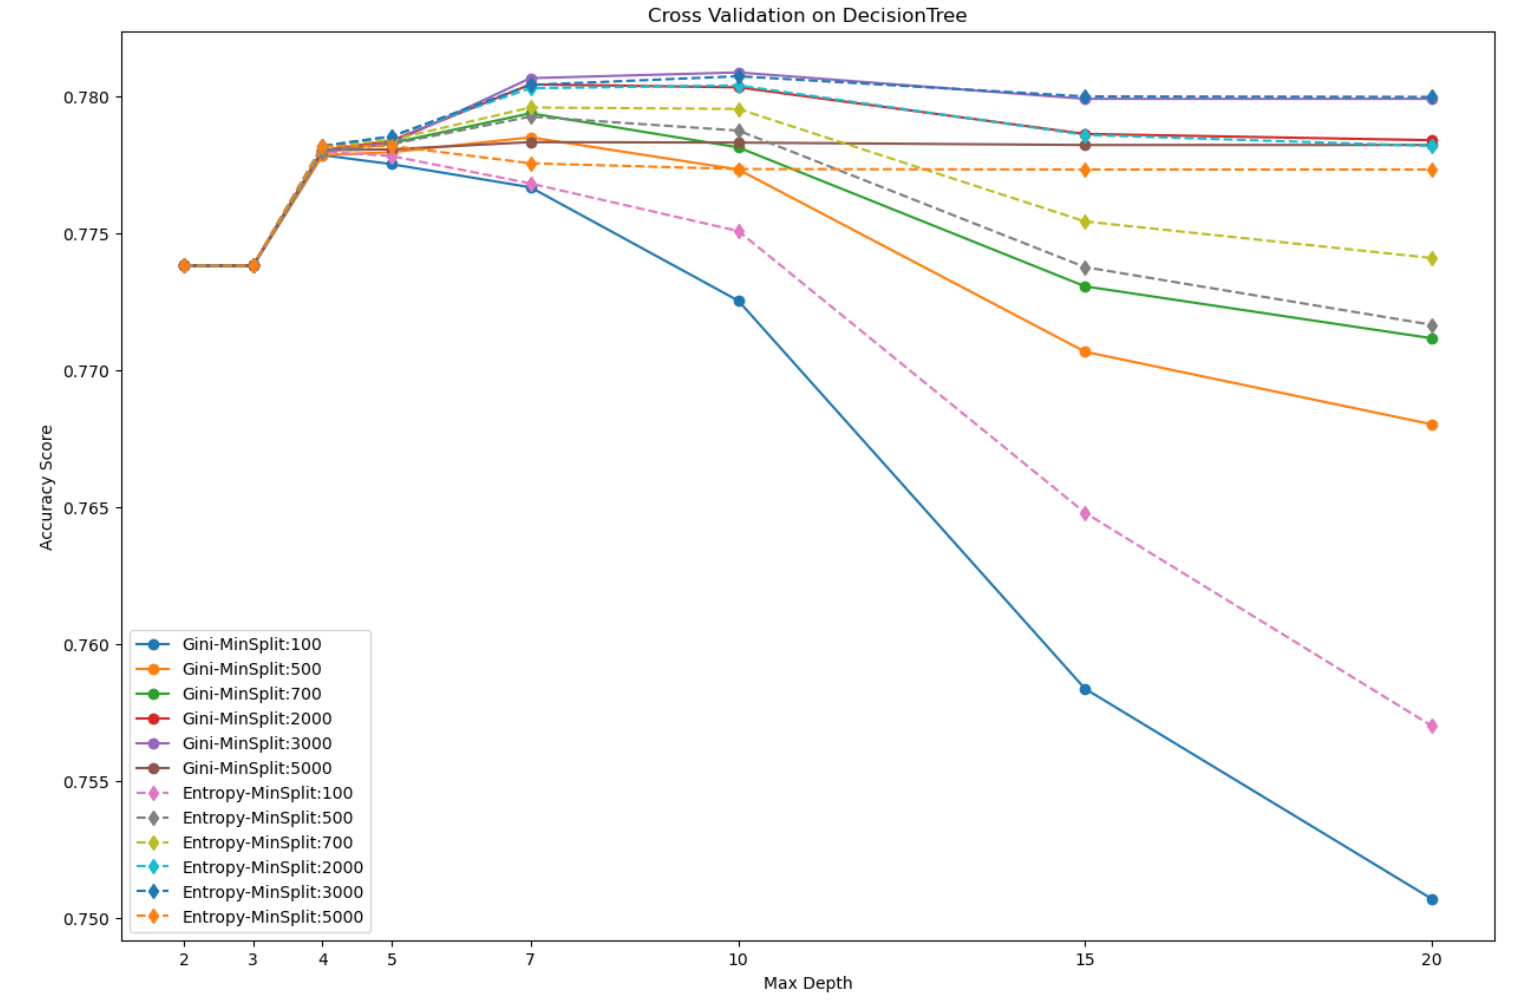

Most of the accuracy curves follow an upward trend then drop down as the max depth grows.  
The first anchor we will choose is:  
Gini-max depth:2 and minimum split sample amount:100. The acurracy score is 0.7738 or all DecisionTree models with max depth at two. So we will randomly choose one.  

Best performance would be: Gini-depth 10 and minimum split: 3000. The accuracy score for this occasion is 0.7809.   

We will also choose Gini-depth 20 and minimum split: 100 as it has the lowest accuracy. This is due to overfitting. We want to check how ensemble behaves when the base classifier is already overfitting. An assumption is that the accuracy will drop further.

#### 3.1.3 SVM
We will test linear SVM, due to the calculation time and the limited scope of the experiment.
The value of the regularization parameter needs to be tuned in study. The larger the regularization parameter is, the more punish is made on misclassification. This usually means we will have high accuracy on train set, but weak generalization ability.  

The mean accuracy scores for different C is [0.7762583775543941, 0.7764161631025265, 0.7765213555171642, 0.7765564186307686].  
We will choose C=0.7 for later testing.

In [ ]:
kernels = ["linear"]
degrees = [3, 4]
C_values = [0.1, 0.5, 0.7, 1.0]           
           
for kernel in kernels:
    if kernel!="rbf":
        print("SVM: {}".format(kernel))
        accuracy_scores = []
        for C in C_values:
            print("C: {}".format(C))
            svm_params = {"kernel": kernel, "C": C}
            model = SVC(**svm_params)
            results = cross_validate(model, train_x, train_y, cv=5, scoring=scoring)
            accuracy_scores.append(np.mean(results["test_accuracy"]))
        print("Accuracy by regularization parameter: {}".format(accuracy_scores))

### 3.2 Ensemble (No SVM)
In this section, we will focus on studing how ensemble frames' parameters can affect the learning quality. The modifiers will be the models we choose from Section 3.1.   
First we will list the accuarcy scores and Roc-AUC scores for each model. Then run ensembles to compare the prediction quality.

In [34]:
multinomial_nb =  MultinomialNB()
complement_nb = ComplementNB()

dicisiontree_1 = DecisionTreeClassifier(criterion="gini", max_depth=2, min_samples_split=100)
dicisiontree_2 = DecisionTreeClassifier(criterion="gini", max_depth=10, min_samples_split=3000)

classifiers = [multinomial_nb, complement_nb, dicisiontree_1, dicisiontree_2]

#### 3.2.1 Bagging

We will run ablation study on: max iteration, bootstrap ratio, max features and ensemble weight method.

In [ ]:
max_itrs = [2, 3, 10, 25, 50, 100]
ratios = [0.1, 0.7, 0.9]
max_features = [0.5, 0.7, 1.0]
weights = ["uniform", "acc"]

for clf in classifiers:
    for ratio in ratios:
        for max_feature in max_features:
            for weight in weights:
                print("Bagging--base model: {} ratio: {} max_feature: {} weight: {}".format(clf, ratio, max_feature, weight))
                
                accuracy_scores = []
                roc_auc_scores = []
                
                for max_itr in max_itrs:
                    bagging = Bagging(clf, max_itr, ratio, max_feature, weight)
                    bagging.fit(train_x, train_y)
                    proba = bagging.predict_proba(test_x)
                    y_hat = bagging.predict(test_x, proba)
                    
                    accuracy_scores.append(accuracy_score(y_test, y_hat))
                    roc_auc_scores.append(roc_auc_score(y_test, proba[:,1]))
                    
                print("accuracy: {}".format(accuracy_scores))
                print("roc auc: {}".format(roc_auc_scores))
                    
                    

#### MultinomialNB

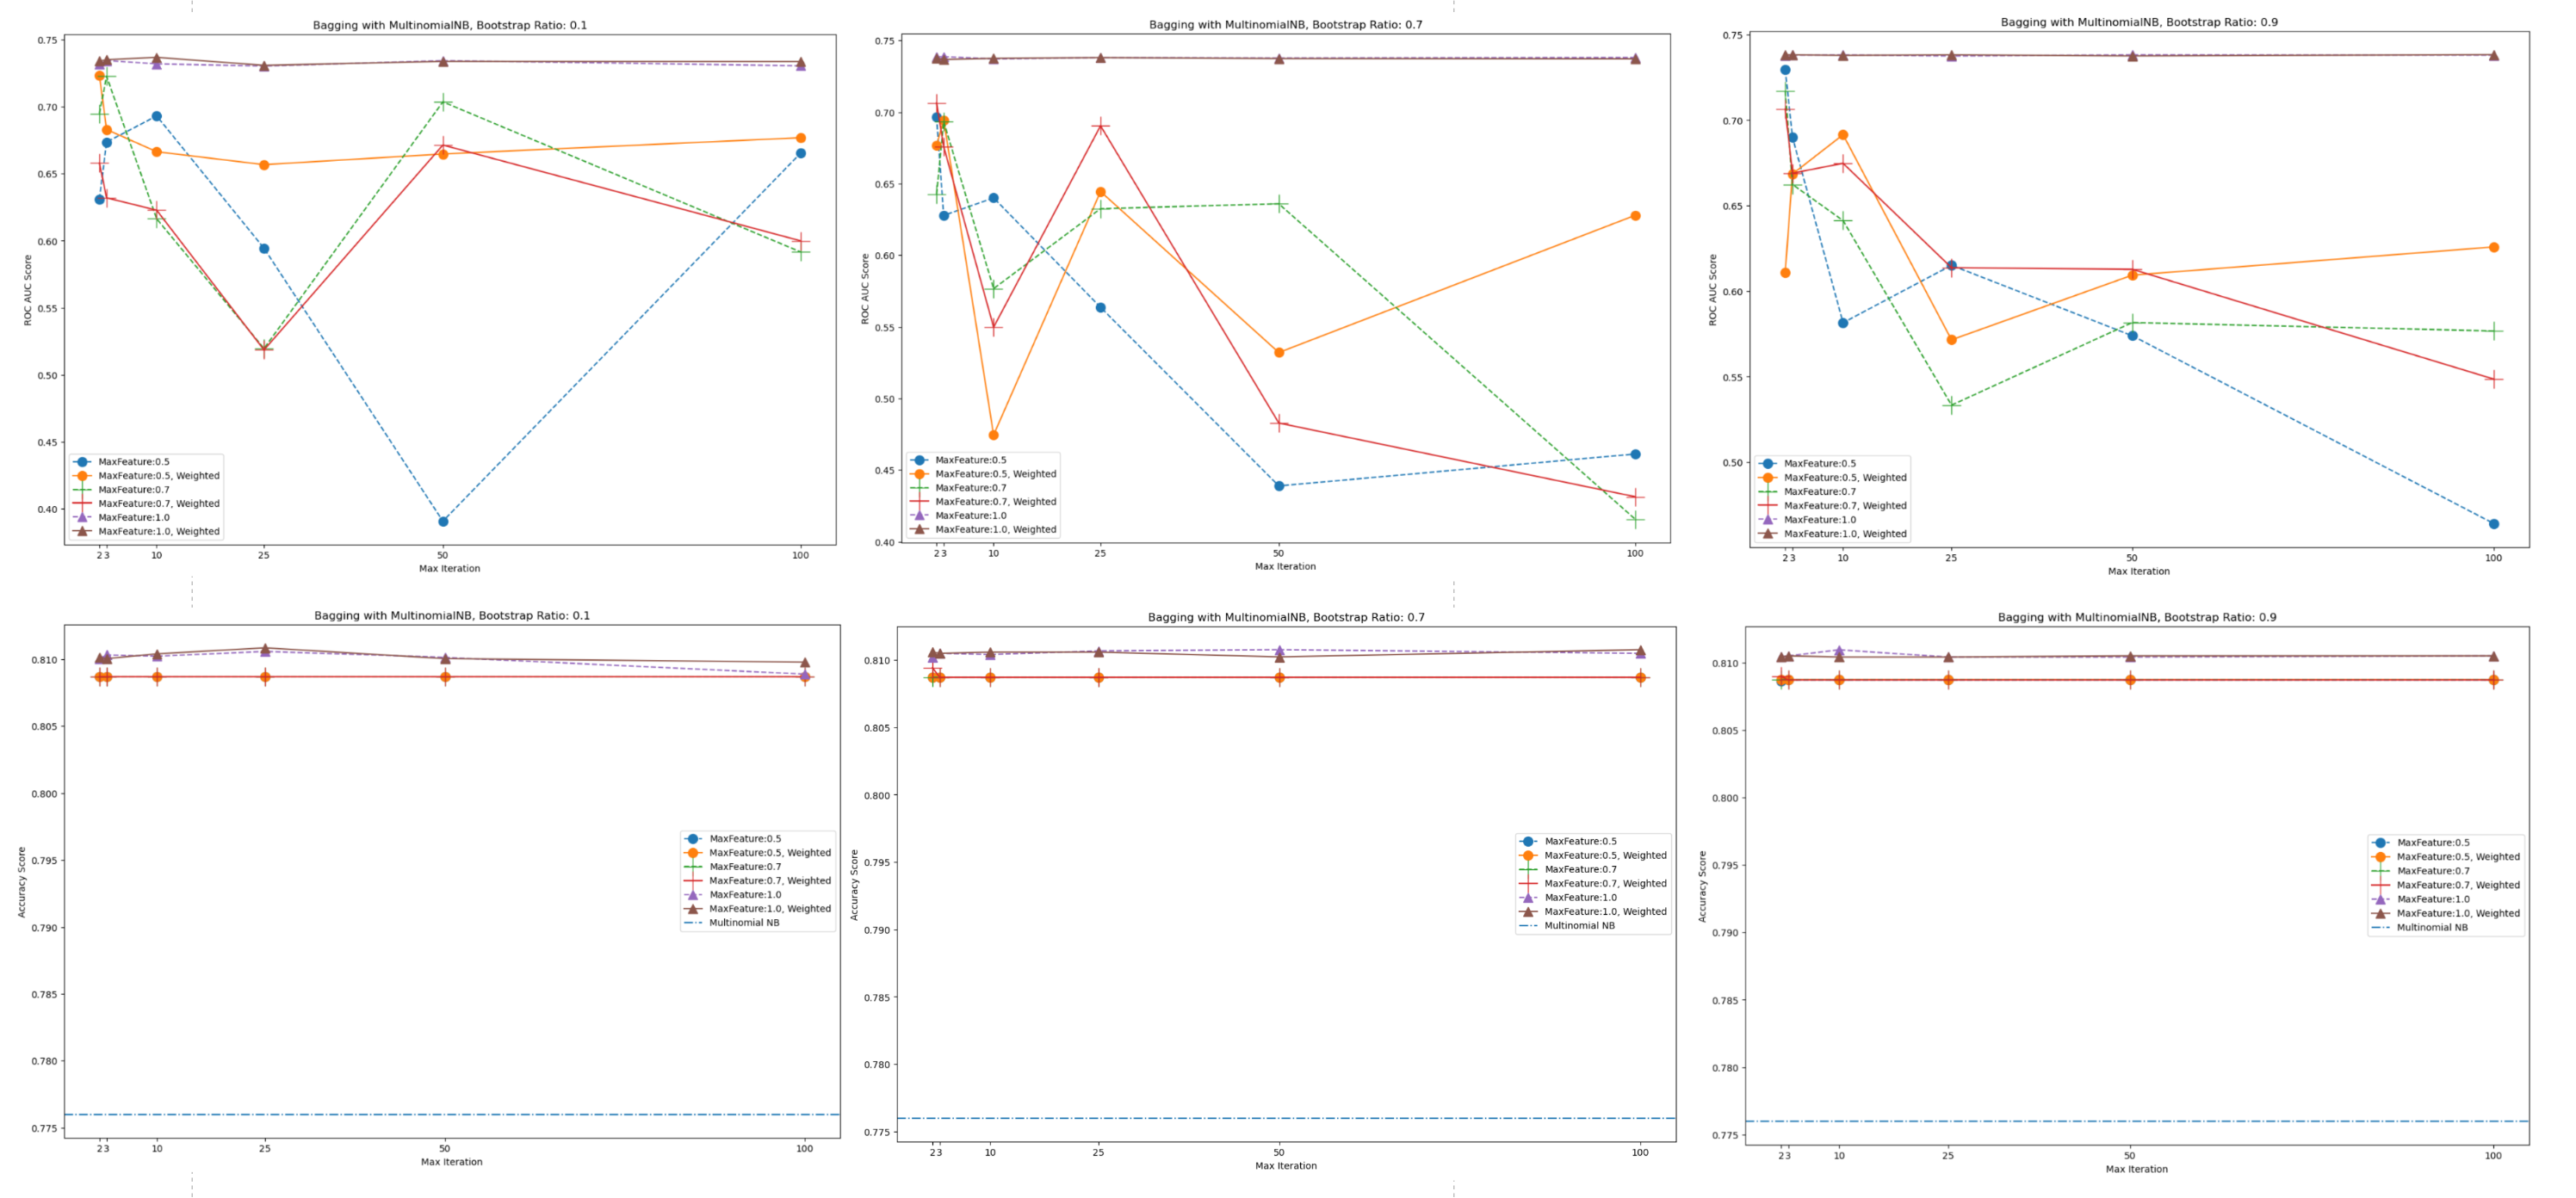

Accuracy for Multinomial Bayes sufficiently improved in Bagging framework. But the Roc AUC scores are not as good as without ensemble learning.  

The best performance is when the bootstrap ratio set to 0.9 and take all features into each bootstrap subsets.  
Taken together accuracy scores and Roc AUC scores, we can see that when we take limited amount of features to train subset models, the accuracy scores are almost unchanges.  

Ensemble with MultinomialNB performs the worst with sample ratio is set to 0.1 and feature ratio=0.5. This is because we take limited information for training, leaving the model underfitting.

As the iteration amount grows, ensemble with weights gets better than non-weighted. The weight we use is based on how accuracy the estimator can be. Thus, estimators with better accuracy will weight more in predict probability calculation. When the iteration amount, also known as the esitimator amount, is limited, the weights would not have such big impact.   

#### ComplementNB
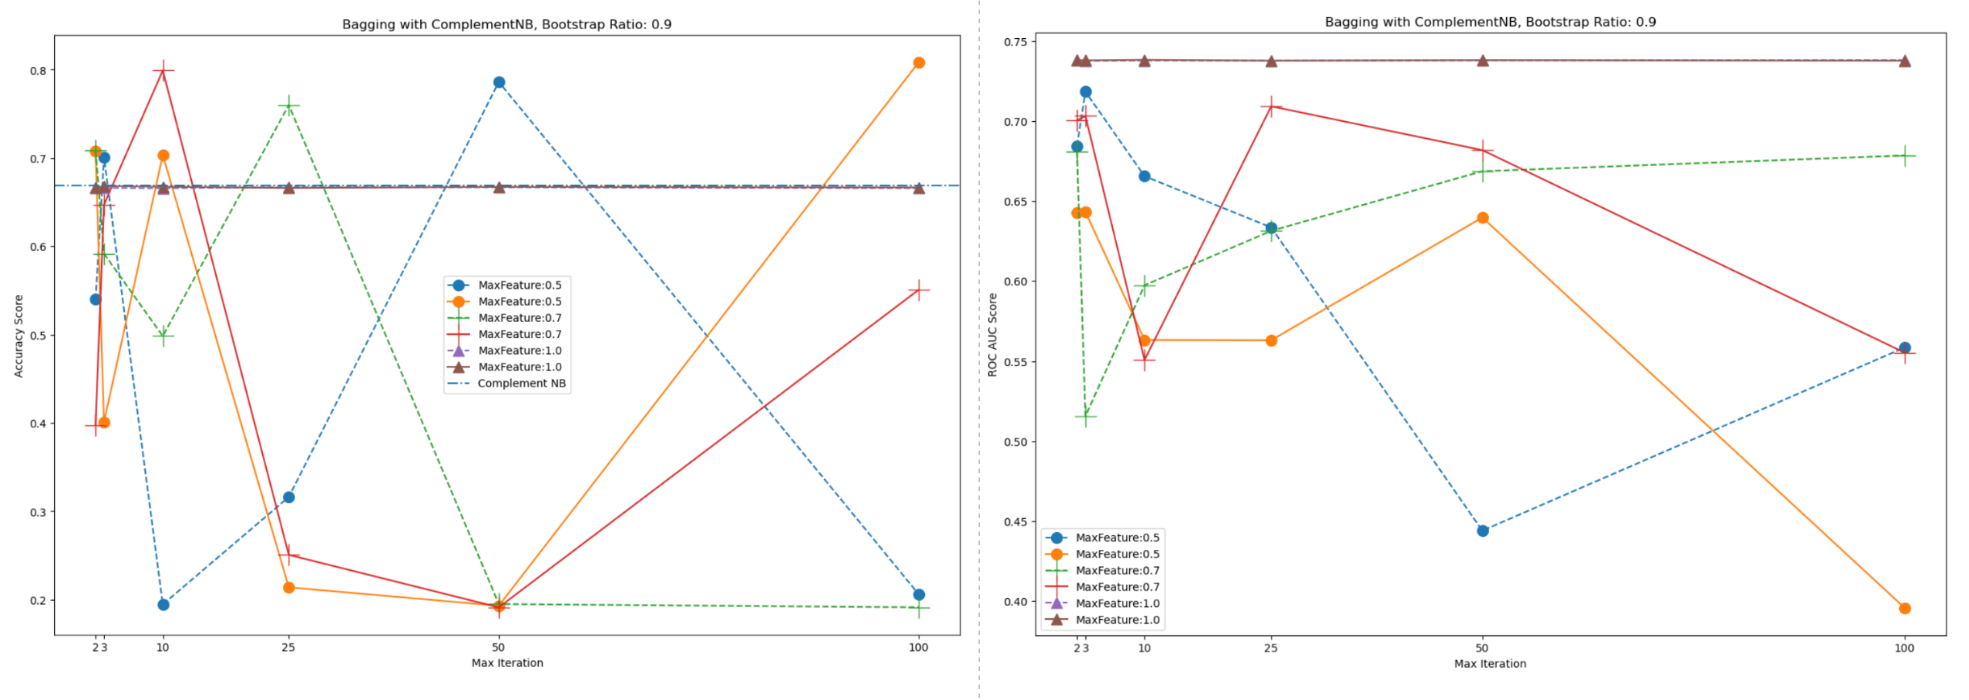  

We only take sample_ratio=0.9 as an example, bagging behaviours with Complement Naive Bayes are like this, unstable, and worse than without using Complement Naive Bayes only.   

One thing need to mention is that Complement Naive Bayes already has the worst performance (Section 3.1.1). Using it as the base model for Bagging framework is basically repeating bad learning and add all the bad results up.  

#### DecisionTree--Max Depth:2, Minimum Split:100 & Max Depth:10, Minimum Split:3000

Under these two base models, the predict accuracy scores for Bagging with different parameters are all around 0.8087080656673804, whilst base model without ensemble has accuracy at 0.7738 and 0.7809. The ensemble brings improvements on accuracy and running speed, as the training subset could be limit to a small amount of data.  

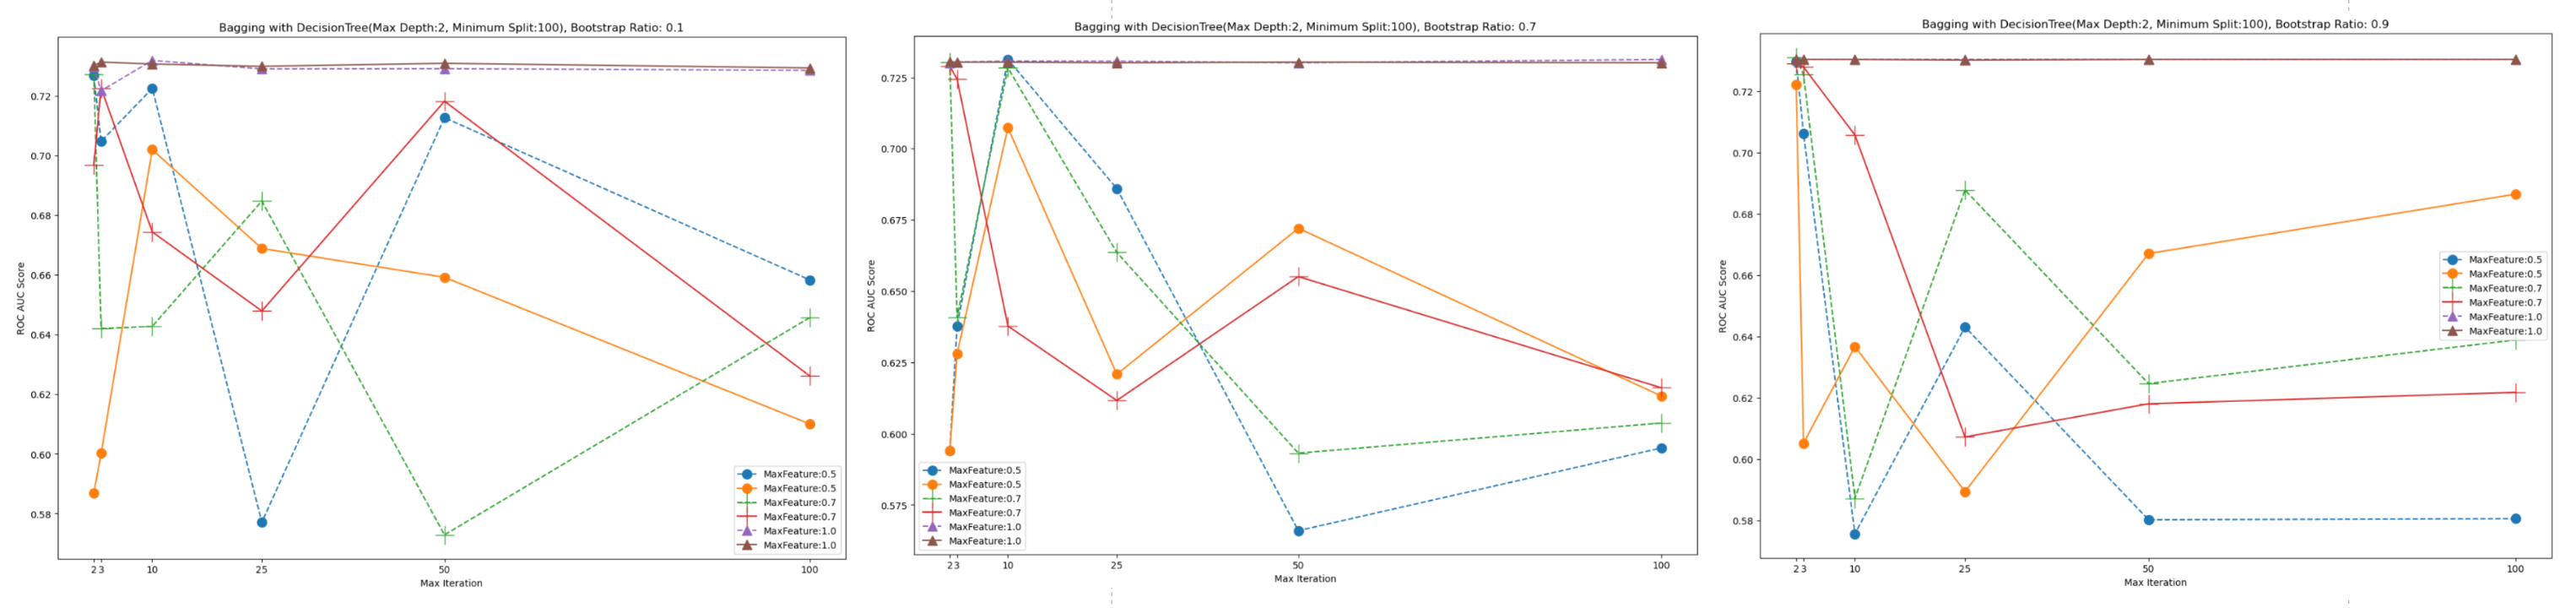
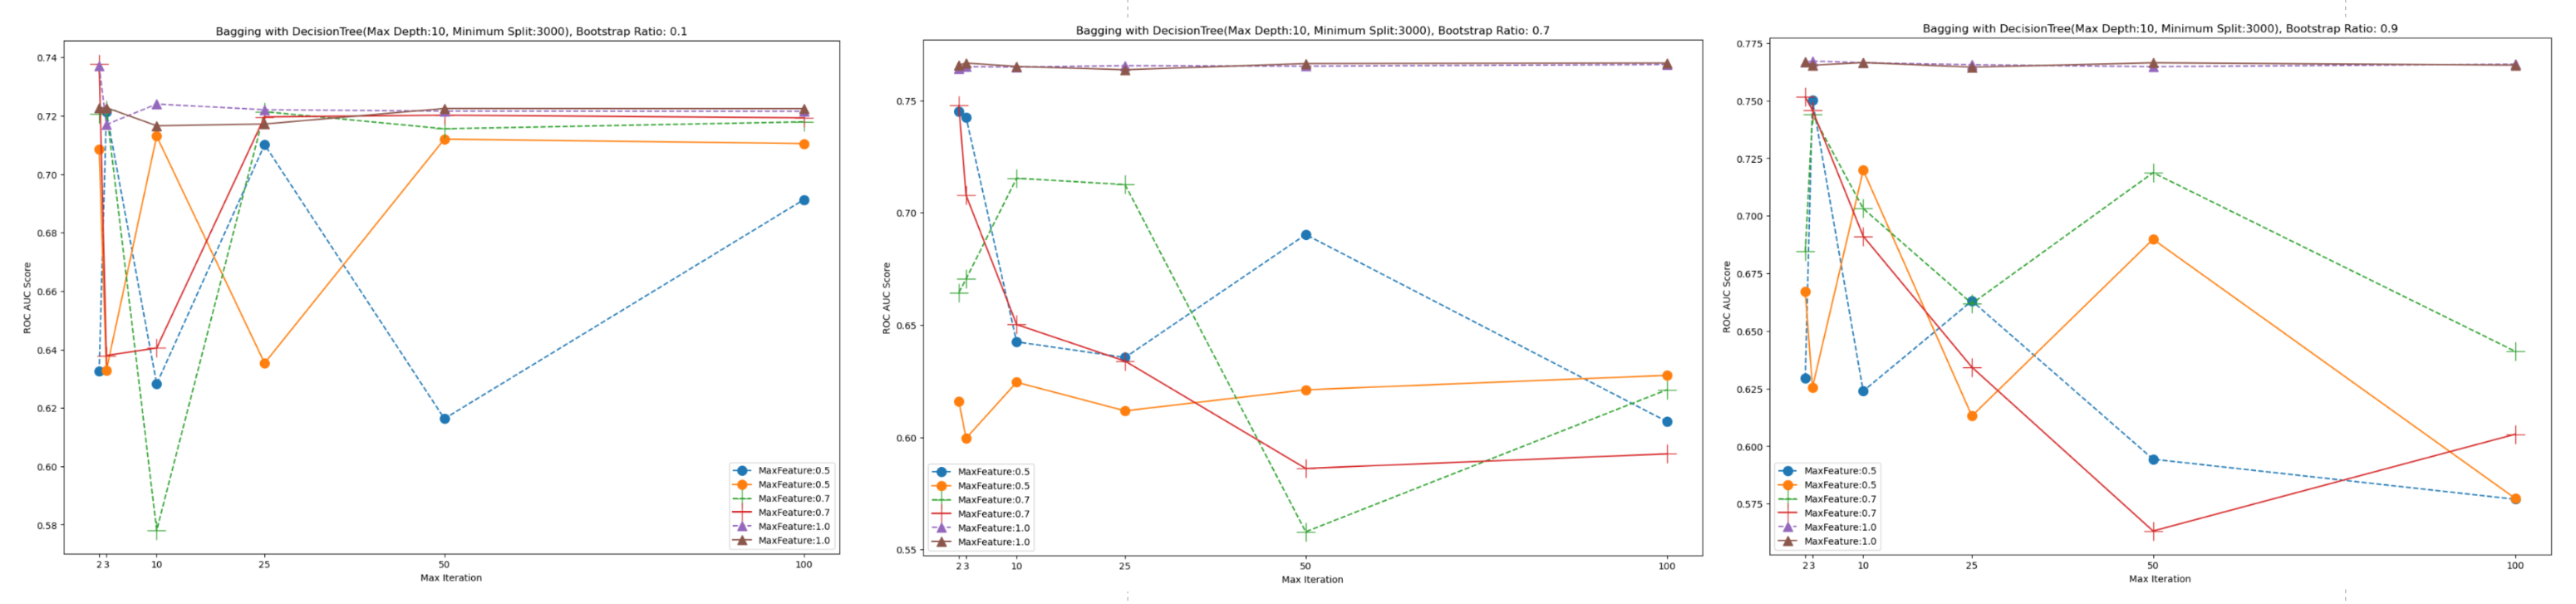

As the iteration(boostrap bag amount) increases to 100, the ROC AUC scores are still low, due to potential overfitting.  
The peak of AUC score is 0.7666653321817656, with Decision Tree -- Max Depth:10, Minimum Split:3000 and Bagging with sample_ratio=0.7 and feature_ratio=1.0.  

When sample ratio is set to 0.1 or 0.9, weighted ensemble has weaker performances then non-weighted ones. The reason is underfitting and overfitting. 

#### 3.2.1 AdaBoost.M1

There is only one parameter in the Adaboost.M1 framework that enquires ablation study: max iteration.

In [92]:
max_itrs = [2, 3, 10, 25, 50, 100]

for clf in classifiers:
    print("Adaboost.M1--base model: {}".format(clf))
    
    accuracy_scores = []
    roc_auc_scores = []
    
    for max_itr in max_itrs:
        adaboost = AdaBoost(clf, max_itr)
        bagging.fit(train_x, train_y)
        proba = bagging.predict_proba(test_x)
        y_hat = bagging.predict(test_x, proba)

        accuracy_scores.append(accuracy_score(y_test, y_hat))
        roc_auc_scores.append(roc_auc_score(y_test, proba[:,1]))
        
    print("accuracy: {}".format(accuracy_scores))
    print("roc auc: {}".format(roc_auc_scores))

Adaboost.M1--base model: MultinomialNB()
accuracy: [0.7772127052105638, 0.7752498215560314, 0.7754282655246253, 0.7829229122055674, 0.7777480371163454, 0.7733761598857959]
roc auc: [0.726195062103977, 0.7355602129879069, 0.7309561628914123, 0.7348074039829535, 0.7298755131420349, 0.7375694789786724]
Adaboost.M1--base model: ComplementNB()
accuracy: [0.7799785867237687, 0.7773911491791577, 0.7821199143468951, 0.7784618129907209, 0.7768558172733762, 0.7750713775874375]
roc auc: [0.7363338111406779, 0.7274658502226292, 0.7324131785495516, 0.735597185766885, 0.7343420924256695, 0.7303382517849851]
Adaboost.M1--base model: DecisionTreeClassifier(max_depth=2, min_samples_split=100)
accuracy: [0.7724839400428265, 0.7749821556031407, 0.7777480371163454, 0.7699857244825125, 0.7727516059957173, 0.7682012847965739]
roc auc: [0.7245538000503878, 0.7370442957048386, 0.7278922593151848, 0.7275961168753541, 0.733340482604629, 0.7275823003253808]
Adaboost.M1--base model: DecisionTreeClassifier(max_dep

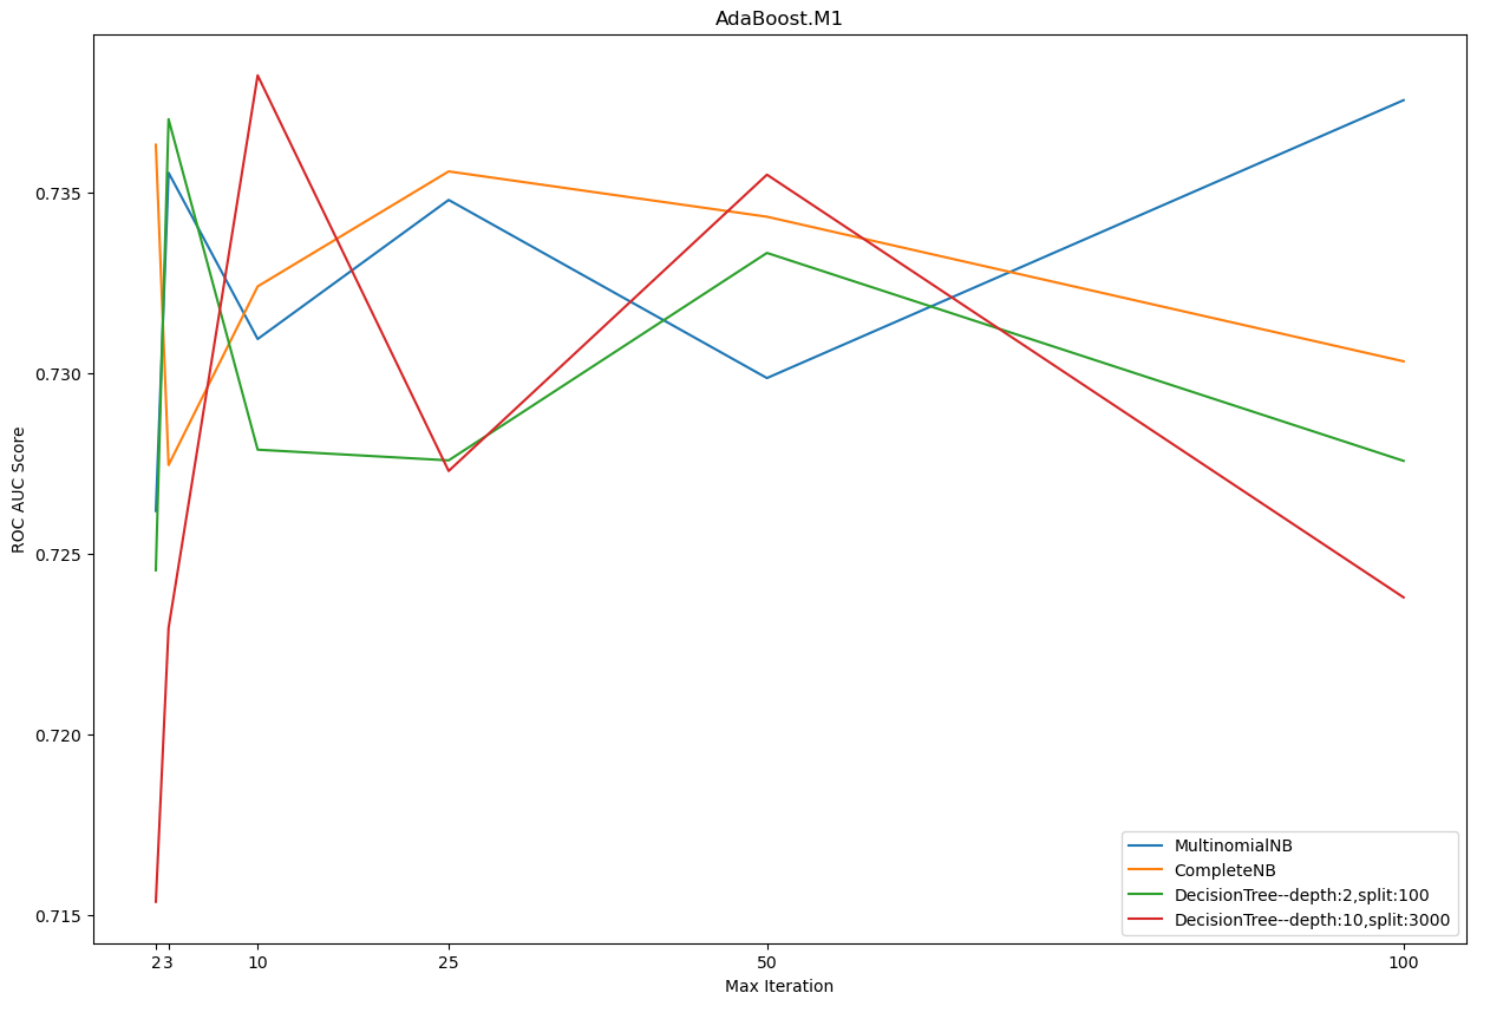

Accuracy scores and Roc AUC scores on Adaboost.M1 are generally lower than Bagging, and higher than without ensemble.   
ref: https://www.linkedin.com/advice/0/how-do-you-choose-between-bagging-boosting-your#:~:text=Bagging%20is%20best%20for%20data,reduce%20underfitting%20and%20increase%20accuracy.  
Bagging is best for data that has high variance, low bias, and low noise, as it can reduce overfitting and increase the model's stability. Boosting is more suitable for data with low variance, high bias, and high noise, as it can reduce underfitting and increase accuracy.

From above analyze, we can assume that our data model has low noise and low bias. We will verify this again with ensemble on SVM.

### 3.3 Ensemble (With SVM)
We will only try max iteration with 2, 3, 5, due to the limit on computility.

In [34]:
svm_params = {"kernel": "linear", "C": 0.7}
clf = SVC(kernel="linear", C=0.7, probability=True)

#### 3.3.1 Bagging

In [ ]:
max_itrs = [2, 3, 5]
ratios = [0.1, 0.7, 0.9]
max_features = [0.5, 0.7, 0.9]
weights = ["uniform", "acc"]


ratios = [0.5, 0.7]

for ratio in ratios:
    for max_feature in max_features:
        for weight in weights:
            print("Bagging ratio: {} max_feature: {} weight: {}".format(ratio, max_feature, weight))

            accuracy_scores = []
            roc_auc_scores = []

            for max_itr in max_itrs:
                bagging = Bagging(clf, max_itr, ratio, max_feature, weight)
                bagging.fit(train_x, train_y)
                proba = bagging.predict_proba(test_x)
                y_hat = bagging.predict(test_x, proba)

                accuracy_scores.append(accuracy_score(y_test, y_hat))
                roc_auc_scores.append(roc_auc_score(y_test, proba[:,1]))

            print("accuracy: {}".format(accuracy_scores))
            print("roc auc: {}".format(roc_auc_scores))
                    
                    

Bagging ratio: 0.1 max_feature: 0.5 weight: uniform  
accuracy: [0.8087080656673804, 0.8087080656673804, 0.8087080656673804]  
roc auc: [0.668047481178617, 0.5439311743357352, 0.3868854748488362]  
Bagging ratio: 0.1 max_feature: 0.5 weight: acc  
accuracy: [0.8088865096359743, 0.8087080656673804, 0.8087080656673804]  
roc auc: [0.6421303607184728, 0.5501616922283991, 0.5879692789911871]  
Bagging ratio: 0.1 max_feature: 0.7 weight: uniform  
accuracy: [0.8087080656673804, 0.8089757316202713, 0.8087080656673804]  
roc auc: [0.6968831612842671, 0.5978105734017468, 0.61847946320362]  
Bagging ratio: 0.1 max_feature: 0.7 weight: acc  
accuracy: [0.7983583154889364, 0.8087080656673804, 0.8087080656673804]  
roc auc: [0.6814161382243681, 0.5219675425827613, 0.46420525557890163]  
Bagging ratio: 0.1 max_feature: 0.9 weight: uniform  
accuracy: [0.7930942184154176, 0.8096002855103498, 0.8087080656673804]  
roc auc: [0.6090184455316093, 0.6818686109391261, 0.5503889320223683]  
Bagging ratio: 0.1 max_feature: 0.9 weight: acc  
accuracy: [0.7505353319057816, 0.8086188436830836, 0.8077266238401142]  
roc auc: [0.6044134949150979, 0.6901153674204002, 0.5601523700451845]  

Bagging ratio: 0.5 max_feature: 0.5 weight: uniform  
accuracy: [0.8093326195574589, 0.8087080656673804, 0.8087080656673804]  
roc auc: [0.5319695926809026, 0.4135500269229756, 0.6242413504795089]  
Bagging ratio: 0.5 max_feature: 0.5 weight: acc  
accuracy: [0.8087080656673804, 0.8087080656673804, 0.8087080656673804]  
roc auc: [0.5923923760225791, 0.6300330321033842, 0.553881405939192]  
Bagging ratio: 0.5 max_feature: 0.7 weight: uniform    
accuracy: [0.8096002855103498, 0.8087080656673804, 0.8087080656673804]    
roc auc: [0.6433575893974522, 0.5328322393987696, 0.6703545105452438]    
Bagging ratio: 0.5 max_feature: 0.7 weight: acc  
accuracy: [0.8090649536045682, 0.8087080656673804, 0.8087080656673804]    
roc auc: [0.6400051334786789, 0.6484083746097403, 0.5730743691625719]    
Bagging ratio: 0.5 max_feature: 0.9 weight: uniform   
accuracy: [0.8096895074946466, 0.8087080656673804, 0.8087080656673804]     
roc auc: [0.6613970636666623, 0.6480170857978422, 0.5797492293606987]  
Bagging ratio: 0.5 max_feature: 0.9 weight: acc    
accuracy: [0.809243397573162, 0.8087080656673804, 0.8087080656673804]      
roc auc: [0.5731868569772497, 0.6182212455210707, 0.6460300240577782]      


Bagging ratio: 0.7 max_feature: 0.5 weight: uniform  
accuracy: [0.808083511777302, 0.808083511777302, 0.8081727337615988]  
roc auc: [0.533461316953406, 0.6126128068560551, 0.6315862490284675]  
Bagging ratio: 0.7 max_feature: 0.5 weight: acc  
accuracy: [0.8087080656673804, 0.8087080656673804, 0.8087080656673804]  
roc auc: [0.5755256361067567, 0.6523548649899225, 0.5647449192146066]  
Bagging ratio: 0.7 max_feature: 0.7 weight: uniform  
accuracy: [0.8087080656673804, 0.8087080656673804, 0.8087080656673804]  
roc auc: [0.6519706774215858, 0.6711844812510704, 0.5459687166550302]  
Bagging ratio: 0.7 max_feature: 0.7 weight: acc  
accuracy: [0.8084403997144897, 0.8087080656673804, 0.8087080656673804]  
roc auc: [0.670575678261385, 0.6609085701512298, 0.6289382055960271]  
Bagging ratio: 0.7 max_feature: 0.9 weight: uniform  
accuracy: [0.8096002855103498, 0.8087080656673804, 0.8087080656673804]    
roc auc: [0.6712181349705576, 0.6387494998254536, 0.5832860603206387]  
Bagging ratio: 0.7 max_feature: 0.9 weight: acc  
accuracy: [0.8093326195574589, 0.8087080656673804, 0.8087080656673804]  
roc auc: [0.5632096612315738, 0.6822765207776211, 0.565423654015887]


Without ensembling, the accuracy score for SVM is around 0.777. With ensembling, the accuracy scores are mostly more than 0.8. It is fair to say that Bagging has improved the accuracy at a limited rate.  

However, regardless of the combination of Bagging parameters, the ROC AUC scores mainly fall into the 0.6-0.7 range. 
Based on the nature of ROC AUC scores, we could conclude that Bagging + LinearSVM does not fit on our data model that well.


#### 3.3.2 Adaboost.M1

In [ ]:
max_itrs = [2, 3, 5]
    
accuracy_scores = []
roc_auc_scores = []

for max_itr in max_itrs:
    adaboost = AdaBoost(clf, max_itr)
    adaboost.fit(train_x, train_y)
    proba = adaboost.predict_proba(test_x)
    y_hat = adaboost.predict(test_x, proba)

    accuracy_scores.append(accuracy_score(y_test, y_hat))
    roc_auc_scores.append(roc_auc_score(y_test, proba[:,1]))

print("accuracy: {}".format(accuracy_scores))
print("roc auc: {}".format(roc_auc_scores))

accuracy: [0.8075481798715204, 0.5729835831548894, 0.5745895788722342]  
roc auc: [0.7790969338271133, 0.7542650171747177, 0.7535119766074745]  

## 4. Final Model

Based on Section 3, we will use below models as final models for conclusion:  
1. Bagging + DecisionTree--Gini, Max Depth:2, Minimum Split:100
2. AdaBoost.M1--Itr:2 + LinearSVM--C=0.7

In [35]:
pred_pd = ground_truth

In [41]:
tree = DecisionTreeClassifier(criterion="gini", max_depth=10, min_samples_split=3000)
svm = SVC(kernel="linear", C=0.7, probability=True)

In [ ]:
# bagging+tree AUC 0.7657723250747586
bagging = Bagging(tree, 3, 0.7, 1.0, "acc")
bagging.fit(train_x, train_y)

class_1_proba = bagging.predict_proba(test_x)
pred_pd["bagging+tree"] = class_1_proba[:,1]

roc_auc_score(y_test, class_1_proba[:,1])

In [ ]:
# adaboost.m1 AUC 0.7790969338271133
adaboost = AdaBoost(svm, 2)
adaboost.fit(train_x, train_y)

class_1_proba = adaboost.predict_proba(test_x)
pred_pd["adaboost+svm"] = class_1_proba[:,1]

roc_auc_score(y_test, class_1_proba[:,1])

In [ ]:
# bagging+svm AUC 0.5653535163711452
bagging = Bagging(svm, 3, 0.5, 0.5, "acc")
bagging.fit(train_x, train_y)

class_1_proba = bagging.predict_proba(test_x)
pred_pd["bagging+svm"] = class_1_proba[:,1]

roc_auc_score(y_test, class_1_proba[:,1])

In [ ]:
# adaboost+tree AUC 0.7625240721865079
adaboost = AdaBoost(svm, 2)
adaboost.fit(train_x, train_y)

class_1_proba = adaboost.predict_proba(test_x)
pred_pd["adaboost+tree"] = class_1_proba[:,1]

roc_auc_score(y_test, class_1_proba[:,1])

In [2]:
bagging = pd.read_csv('./bagging.csv')
boosting = pd.read_csv('./boosting.csv')

In [5]:
bagging["adaboost+tree"] = boosting["adaboost+tree"]
bagging["adaboost+svm"] = boosting["adaboost+svm"]

In [8]:
bagging.to_csv("./proba.csv", encoding='utf-8', index=False)

In [9]:
final_proba = pd.read_csv('./proba.csv')
final_proba

Id  Expected  bagging+tree  bagging+svm  adaboost+tree  adaboost+svm
0          0         0      0.014897     0.220084       0.021900      0.083968
1          1         0      0.318827     0.220060       0.419826      0.162375
2          2         0      0.093439     0.220079       0.137870      0.183057
3          3         0      0.283920     0.220067       0.290665      0.392330
4          4         0      0.283920     0.220085       0.290665      0.530601
...      ...       ...           ...          ...            ...           ...
11203  11203         0      0.318827     0.238375       0.525937      0.294773
11204  11204         0      0.168085     0.220087       0.564866      0.327576
11205  11205         0      0.281553     0.287514       0.355633      0.619885
11206  11206         0      0.780328     0.420128       0.461163      0.930132
11207  11207         0      0.014897     0.220062       0.021900      0.014189

[11208 rows x 6 columns]

## Summary

The best performances on the test set are carried out by:  
1. Bagging + DecisionTree--Gini, Max Depth:2, Minimum Split:100 (ROC AUC: 0.76) 
2. AdaBoost.M1--Itr:2 + LinearSVM--C=0.7(ROC AUC: 0.80).  

The decision boundary of SVM (with or without kernel) is always linear (in the kernel space or not)
while the decision boundary of the decision tree is piecewise linear ( non-linear). This could be a
reason why these two base models work differently with Bagging and with Boosting.  

Although Bagging is marked as “almost useful in all circumstances”, it still highly relies on the
features and sample ratios when forming a training subset. When these two ratios are set to
extremely low, underfitting can happen; When both are set high and the iteration amount is large, the
learning results can be easily overfitted.  

Boosting algorithms can easily lead to overfitting too. Take the SVM for example, the SVM already
carries out a high accuracy on our data model, and as the iteration amount of boosting increase,
most of the time, the ROC AUC scores start to follow a downward trend.  

The experiment can hardly be qualified as complete in our case. To improve the structure and make
the data more comprehensive, we could do:
4. Bagging and Boosting Parameter Study on validation set (now on test set)
5. More unstable classifiers to see how Bagging and Boosting work with them
6. More testing with different data preprocessing, for example: more/less features extracted from vectorization, other ways to map textual contents to numeric